## Forecasting

In [131]:
# !pip3 install pmdarima

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

# from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

FREQ = 60

from sklearn.model_selection import TimeSeriesSplit

### Load and prepare data

In [133]:
df = pd.read_csv('MATICBUSD_trades_1m_preprocessed.csv')
df

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price,ATR,OBV,RSI,AD
0,2022-11-11 14:38:00,0.9969,0.9969,0.9903,0.9905,220208.0,77,0.993500,NaN,220208.0,NaN,-2.068621e+05
1,2022-11-11 14:39:00,0.9907,0.9927,0.9884,0.9884,101645.0,68,0.990534,NaN,118563.0,NaN,-3.085071e+05
2,2022-11-11 14:40:00,0.9881,0.9909,0.9875,0.9893,124742.0,64,0.989423,NaN,243305.0,NaN,-3.011693e+05
3,2022-11-11 14:41:00,0.9891,0.9949,0.9883,0.9932,165038.0,69,0.991930,NaN,408343.0,NaN,-2.211509e+05
4,2022-11-11 14:42:00,0.9942,0.9950,0.9899,0.9899,159318.0,66,0.993091,NaN,249025.0,NaN,-3.804689e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
66856,2022-12-29 23:55:00,0.7767,0.7768,0.7765,0.7768,640.0,7,0.776618,0.000534,6513191.0,57.790372,-5.297411e+07
66857,2022-12-29 23:56:00,0.7770,0.7770,0.7768,0.7768,4820.0,5,0.776874,0.000512,6513191.0,57.790372,-5.297893e+07
66858,2022-12-29 23:57:00,0.7769,0.7771,0.7769,0.7771,4890.0,2,0.777077,0.000498,6518081.0,60.729481,-5.297404e+07
66859,2022-12-29 23:58:00,0.7771,0.7771,0.7767,0.7767,3447.0,3,0.776950,0.000491,6514634.0,55.235070,-5.297749e+07


In [134]:
df = df.dropna()
df['Ts'] = pd.to_datetime(df['Ts'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66846 entries, 15 to 66860
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ts         66846 non-null  datetime64[ns]
 1   Open       66846 non-null  float64       
 2   High       66846 non-null  float64       
 3   Low        66846 non-null  float64       
 4   Close      66846 non-null  float64       
 5   Volume     66846 non-null  float64       
 6   Rec_count  66846 non-null  int64         
 7   Avg_price  66846 non-null  float64       
 8   ATR        66846 non-null  float64       
 9   OBV        66846 non-null  float64       
 10  RSI        66846 non-null  float64       
 11  AD         66846 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 6.6 MB


/tmp/ipykernel_2753942/2115375197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ts'] = pd.to_datetime(df['Ts'])


In [135]:
cols = ['Open', 'High', 'Low', 'RSI', 'Volume', 'Rec_count', 'Avg_price']

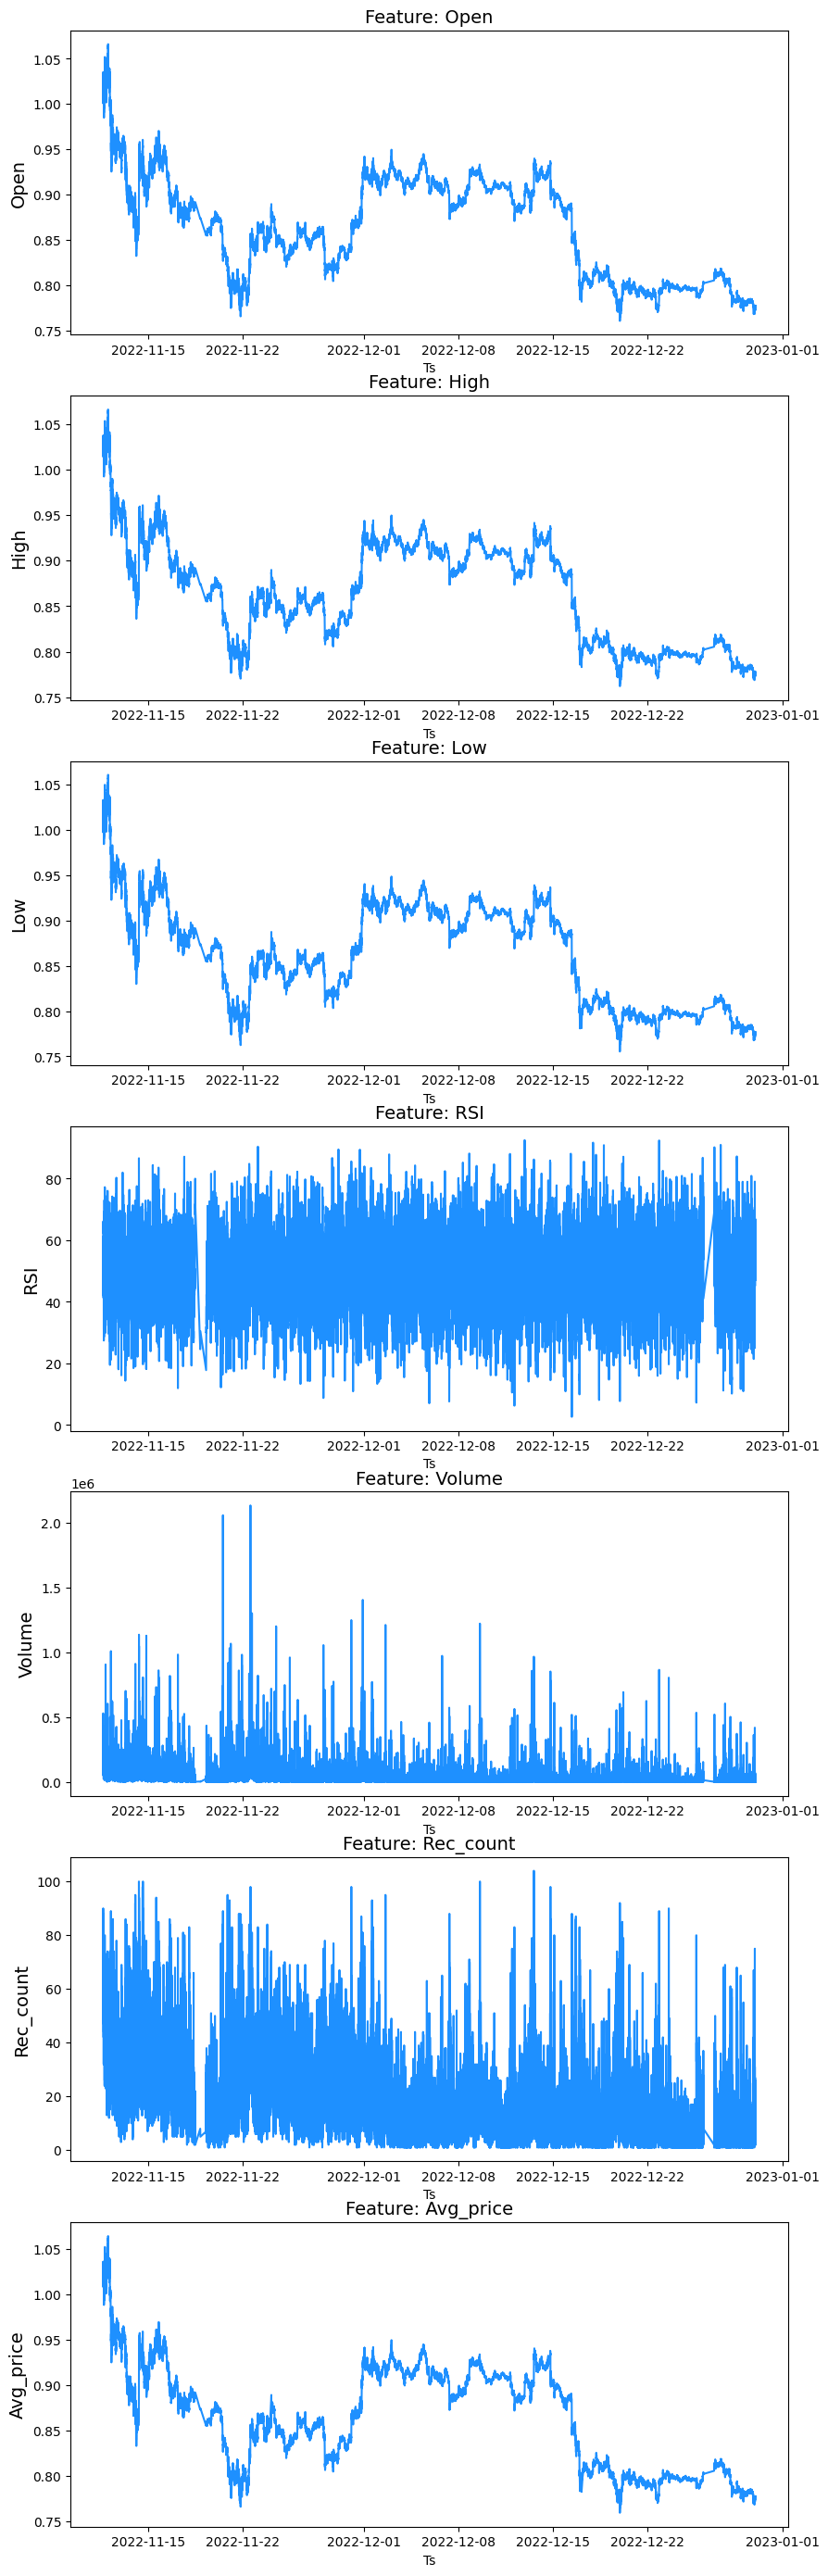

In [136]:
f, ax = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 35))

for i, col in enumerate(cols):
    sns.lineplot(x=df['Ts'], y=df[col], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: ' + col, fontsize=14)
    ax[i].set_ylabel(ylabel=col, fontsize=14)
plt.show()

### Chronological Order and Equidistant Timestamps

In [137]:
df2 = df.copy()
df2 = df2.sort_values(by='Ts')

# Check time intervals
df2['diff'] = df2['Ts'] - df2['Ts'].shift(1)
df2[['Ts', 'diff']].head()

,Ts,diff
15,2022-11-11 14:53:00,NaT
16,2022-11-11 14:54:00,0 days 00:01:00
17,2022-11-11 14:55:00,0 days 00:01:00
18,2022-11-11 14:56:00,0 days 00:01:00
19,2022-11-11 14:57:00,0 days 00:01:00


In [138]:
df2['diff'].value_counts()

diff
0 days 00:01:00    66429
0 days 00:02:00      382
0 days 00:03:00       20
0 days 00:04:00        4
0 days 00:06:00        2
0 days 00:50:00        1
0 days 08:49:00        1
0 days 00:20:00        1
0 days 10:11:00        1
0 days 00:05:00        1
0 days 00:16:00        1
0 days 00:15:00        1
0 days 18:59:00        1
Name: count, dtype: int64

In [139]:
# Exclude recots with big intervals ( > 4 minutes)
df2 = df2[df2['diff'].dt.total_seconds() <= 4 * 60]

In [140]:
df2 = df2.resample('1min', on='Ts').mean().ffill().reset_index(drop=False)

In [141]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69666 entries, 0 to 69665
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   Ts         69666 non-null  datetime64[ns] 
 1   Open       69666 non-null  float64        
 2   High       69666 non-null  float64        
 3   Low        69666 non-null  float64        
 4   Close      69666 non-null  float64        
 5   Volume     69666 non-null  float64        
 6   Rec_count  69666 non-null  float64        
 7   Avg_price  69666 non-null  float64        
 8   ATR        69666 non-null  float64        
 9   OBV        69666 non-null  float64        
 10  RSI        69666 non-null  float64        
 11  AD         69666 non-null  float64        
 12  diff       69666 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(11), timedelta64[ns](1)
memory usage: 6.9 MB


In [142]:
offset = df2['Ts'].max() - pd.DateOffset(days=2)

In [143]:
offset_df = df2[df2['Ts'] > offset]

In [144]:
offset_df

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price,ATR,OBV,RSI,AD,diff
66786,2022-12-28 00:00:00,0.8058,0.8062,0.8056,0.8059,44692.0,34.0,0.805821,0.000283,11854976.0,56.764720,-5.089017e+07,0 days 00:01:00
66787,2022-12-28 00:01:00,0.8062,0.8062,0.8060,0.8061,14041.0,21.0,0.806062,0.000284,11869017.0,59.252432,-5.089017e+07,0 days 00:01:00
66788,2022-12-28 00:02:00,0.8060,0.8062,0.8057,0.8062,13129.0,19.0,0.805909,0.000298,11882146.0,60.470894,-5.087704e+07,0 days 00:01:00
66789,2022-12-28 00:03:00,0.8064,0.8067,0.8064,0.8067,22571.0,7.0,0.806466,0.000312,11904717.0,65.928853,-5.085447e+07,0 days 00:01:00
66790,2022-12-28 00:04:00,0.8068,0.8072,0.8068,0.8070,9071.0,11.0,0.806886,0.000324,11913788.0,68.706528,-5.085447e+07,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69661,2022-12-29 23:55:00,0.7767,0.7768,0.7765,0.7768,640.0,7.0,0.776618,0.000534,6513191.0,57.790372,-5.297411e+07,0 days 00:01:00
69662,2022-12-29 23:56:00,0.7770,0.7770,0.7768,0.7768,4820.0,5.0,0.776874,0.000512,6513191.0,57.790372,-5.297893e+07,0 days 00:01:00
69663,2022-12-29 23:57:00,0.7769,0.7771,0.7769,0.7771,4890.0,2.0,0.777077,0.000498,6518081.0,60.729481,-5.297404e+07,0 days 00:01:00
69664,2022-12-29 23:58:00,0.7771,0.7771,0.7767,0.7767,3447.0,3.0,0.776950,0.000491,6514634.0,55.235070,-5.297749e+07,0 days 00:01:00


### Avg_price Analysis

In [145]:
def stationarity_chart(df, col, rolling_window=FREQ):
    plt.figure()
    plt.subplots(figsize = (20,10))
    sns.lineplot(x=df['Ts'], y=df[col], color='dodgerblue', label=col)
    sns.lineplot(x=df['Ts'], y=df[col].rolling(rolling_window).mean(), color='black', label='rolling mean')
    sns.lineplot(x=df['Ts'], y=df[col].rolling(rolling_window).std(), color='red', label='rolling std')
    # sns.set_title('Feature: ' + col, fontsize=14)
    #sns[i].set_ylabel(ylabel=col, fontsize=14)
    plt.show()

<Figure size 640x480 with 0 Axes>

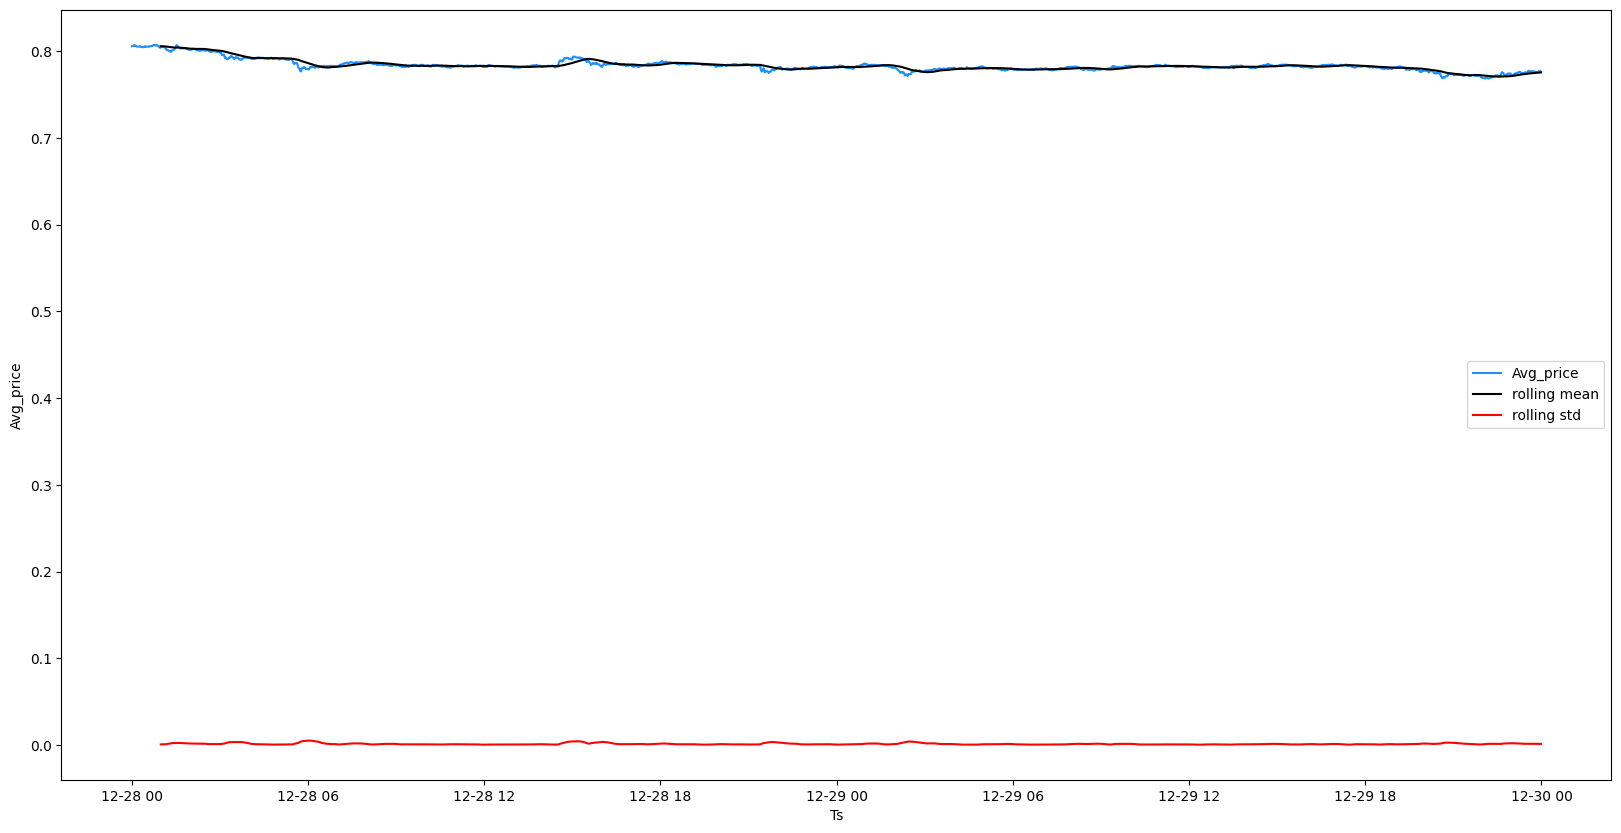

In [146]:
stationarity_chart(offset_df, 'Avg_price')

In [147]:
# Check stationarity of the Avg_price
stats = adfuller(offset_df['Avg_price'])

# **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0),
# the data has a unit root and is non-stationary.

p_value = stats[1]
print("P_value %s" % p_value)

P_value 0.014196806743702026


### Decomposition Avg_price

In [148]:
df3 = offset_df.reset_index()

In [149]:
period = 4 * 60   # 4 hour

def decompose_chart(df, col, period=period):
    fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(16,8))
    res = seasonal_decompose(df[col], period=period, model='additive', extrapolate_trend='freq')

    ax[0,0].set_title(f'Decomposition {col}', fontsize=16)
    res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
    ax[0,0].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
    ax[1,0].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
    ax[0,1].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
    ax[1,1].set_ylabel('Residual', fontsize=14)

    plt.show()

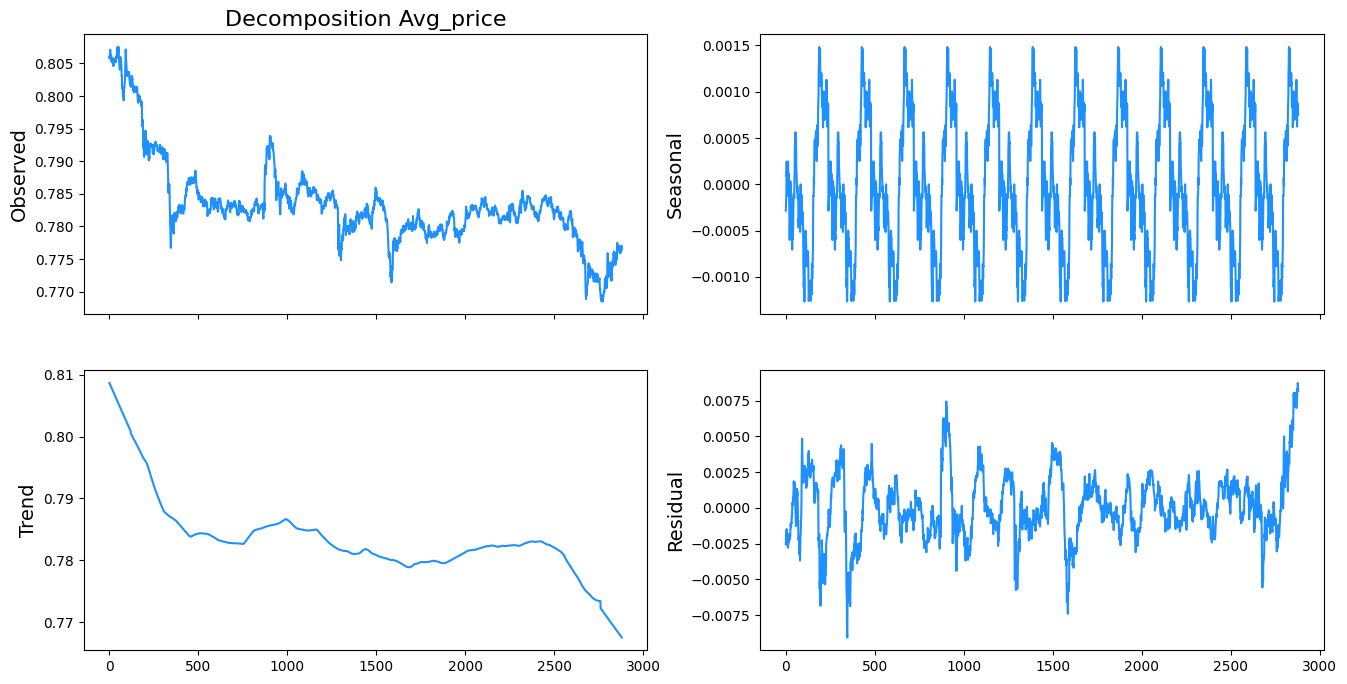

In [150]:
decompose_chart(df3, 'Avg_price')

### Autocorrelation Analysis Avg_price

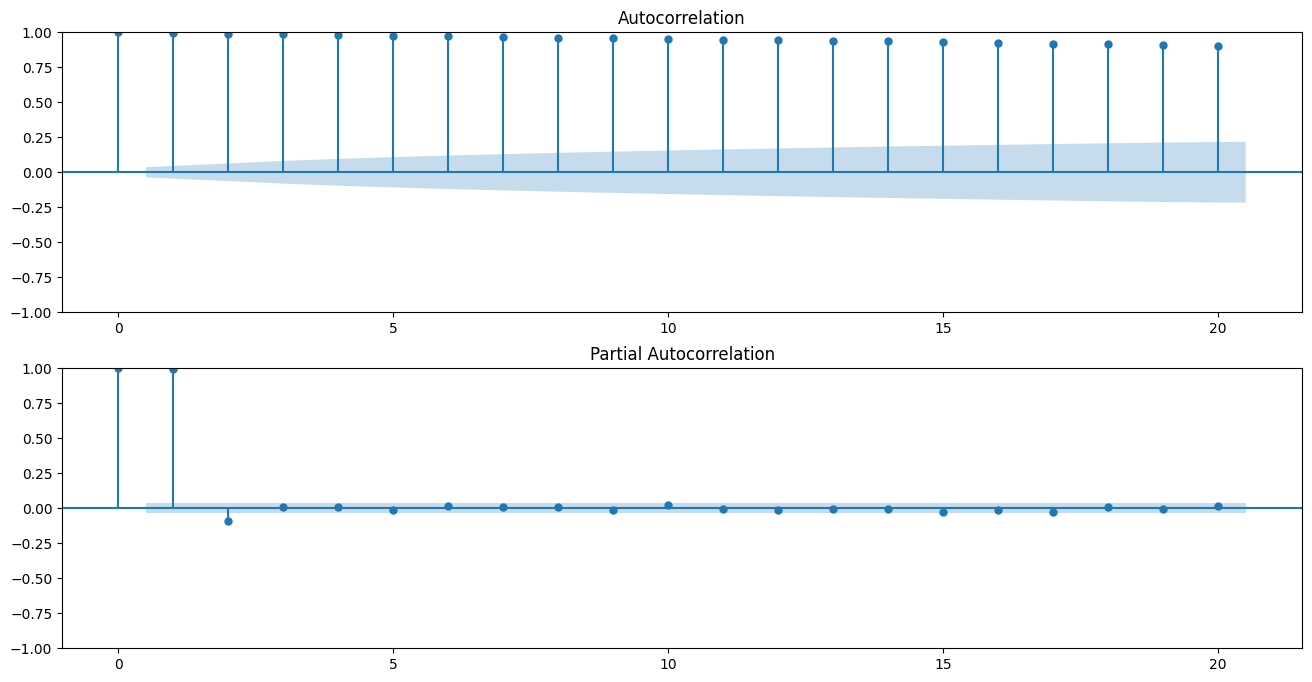

In [151]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df3['Avg_price'],lags=20, ax=ax[0])
plot_pacf(df3['Avg_price'],lags=20, ax=ax[1])
plt.show()

### Utils

In [152]:
def get_metrics(y_train, y_hat_train, y_test, y_hat_test):
    return {
            "r2 train": "%.2f" % metrics.r2_score(y_train, y_hat_train),
            "r2 test": "%.2f" % metrics.r2_score(y_test, y_hat_test),
            "mse train": "%.2f" % metrics.mean_squared_error(y_train, y_hat_train),
            "mse test": "%.2f" % metrics.mean_squared_error(y_test, y_hat_test)
           }

def get_model_metrics(X, y, model, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    model.fit(X_train, y_train)

    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    metrics = get_metrics(y_train, y_hat_train, y_test, y_hat_test)
    metrics["model"] = label
    return metrics

def series_to_supervised(in_data, tar_data, n_in=1, dropnan=True, target_dep=False):
    """
    Transformation into a training sample taking into account the lag
     : param in_data: Input fields
     : param tar_data: Output field (single)
     : param n_in: Lag shift
     : param dropnan: Do destroy empty lines
     : param target_dep: Whether to take into account the lag of the input field If taken into account, the input will start with lag 1
     : return: Training sample. The last field is the source
    """

    n_vars = in_data.shape[1]
    cols, names = list(), list()

    if target_dep:
        i_start = 1
    else:
        i_start = 0
    for i in range(i_start, n_in + 1):
        cols.append(in_data.shift(i))
        names += [('%s(t-%d)' % (in_data.columns[j], i)) for j in range(n_vars)]

    if target_dep:
        for i in range(n_in, -1, -1):
            cols.append(tar_data.shift(i))
            names += [('%s(t-%d)' % (tar_data.name, i))]
    else:
        # put it all together
        cols.append(tar_data)
        names.append(tar_data.name)
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

def get_scaled(df, column, n_in):
    dataset = series_to_supervised(df, df[column], n_in)
    dataset = dataset.drop([column + "(t-0)"], axis=1)
    
    col = dataset.columns
    X, Y = dataset[col[1:-1]], dataset[col[-1]]
    print("Input: ", X.columns)
    print("Target:", Y.name)

    # print(X.head())
    # print(Y.head())

    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    scaled_x = scaler_x.fit_transform(X)
    scaled_y = scaler_y.fit_transform(Y.values.reshape(-1, 1))

    return scaled_x, scaled_y, scaler_x, scaler_y

In [153]:
scaled_x, scaled_y, _, _ = get_scaled(df3['Avg_price'].to_frame(), 'Avg_price', 4)

regressor = LinearRegression()
get_model_metrics(scaled_x, scaled_y, regressor, 'LinearRegression')

Input:  Index(['Avg_price(t-2)', 'Avg_price(t-3)', 'Avg_price(t-4)'], dtype='object')
Target: Avg_price


{'r2 train': '0.99',
 'r2 test': '0.98',
 'mse train': '0.00',
 'mse test': '0.00',
 'model': 'LinearRegression'}

### Volume Analysis

<Figure size 640x480 with 0 Axes>

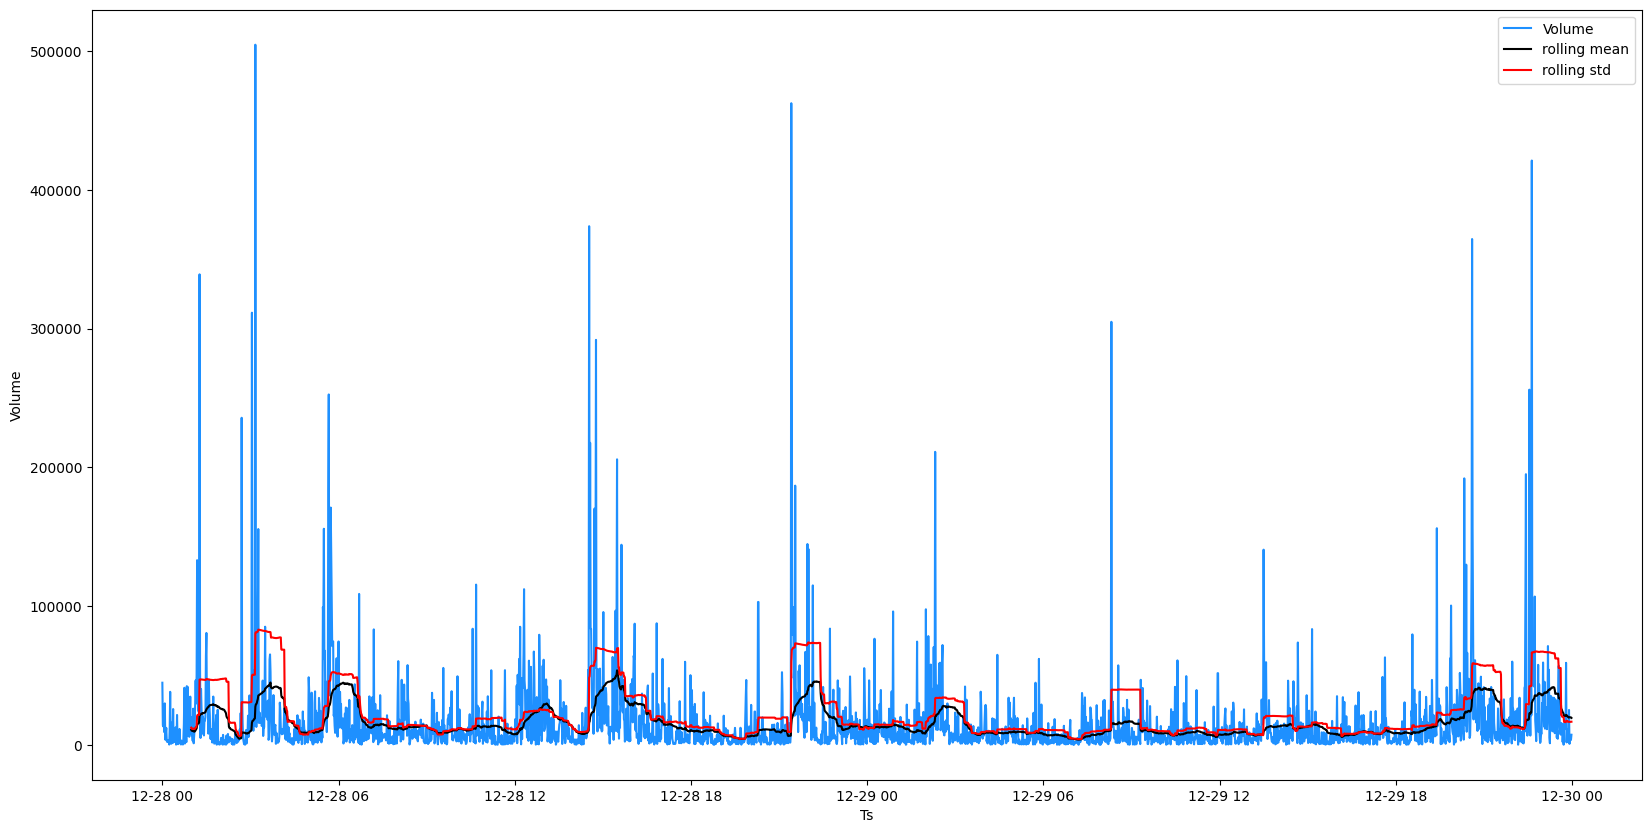

In [154]:
stationarity_chart(df3, 'Volume')

In [155]:
# Check stationarity of the Avg_price
stats = adfuller(df3['Volume'])

# **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0),
# the data has a unit root and is non-stationary.

p_value = stats[1]
print("P_value %s" % p_value)

P_value 8.31120326323984e-15


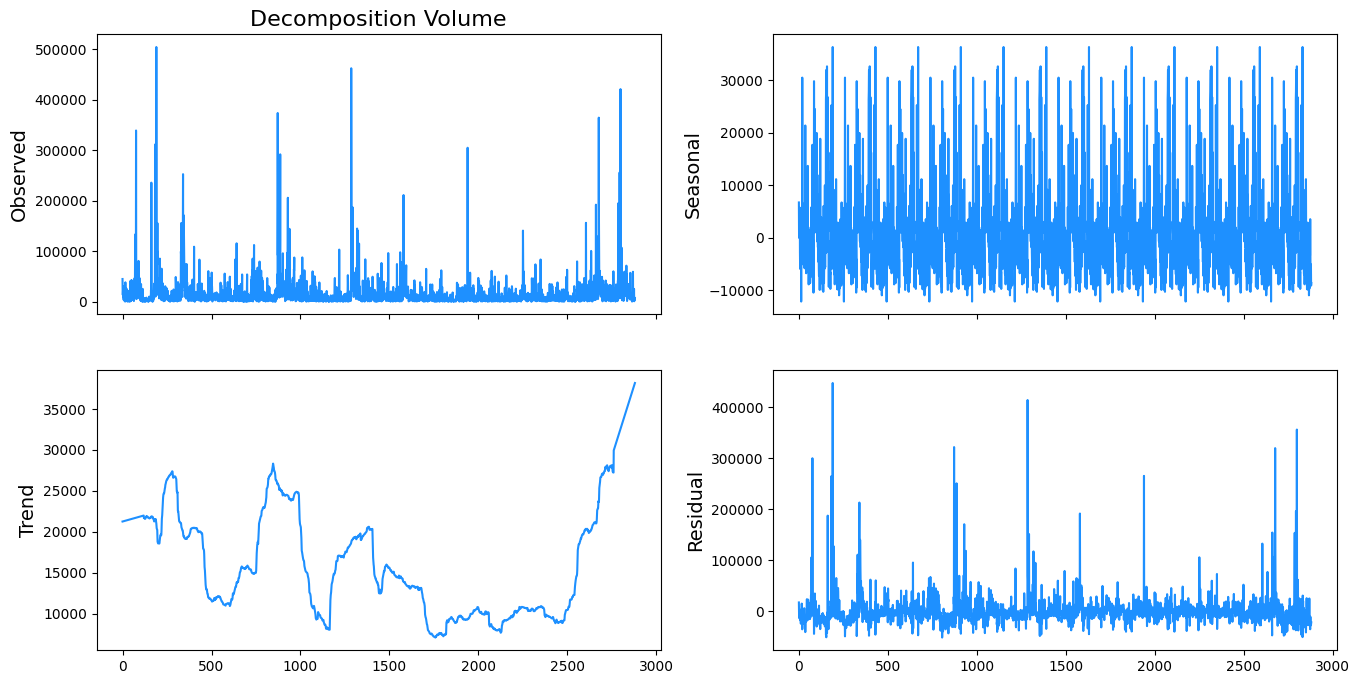

In [156]:
decompose_chart(df3, 'Volume')

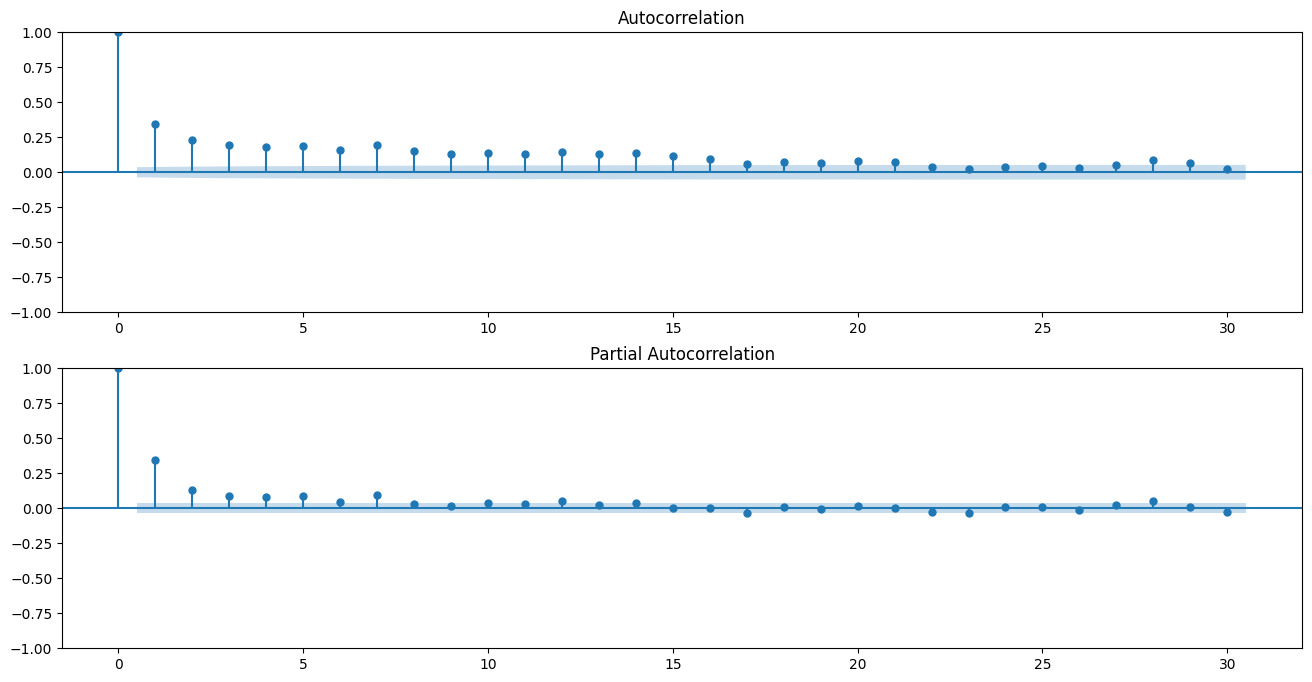

In [157]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df3['Volume'],lags=30, ax=ax[0])
plot_pacf(df3['Volume'],lags=30, ax=ax[1])
plt.show()

In [158]:
# !pip3 install pmdarima

### Arima Model

In [159]:
vdf4 = df3['Volume']
train_len = int(len(vdf4) * 0.9)
print(train_len)
train = vdf4[:train_len]
test = vdf4[train_len:]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True) #, stepwise=False, n_jobs=6)

2592
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=60159.217, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61240.040, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60797.070, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60232.858, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61238.041, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=60159.144, Time=1.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60160.417, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60168.737, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=60158.054, Time=0.72 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=60157.453, Time=1.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=60160.118, Time=0.80 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=60156.818, Time=1.34 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=60134.589, Time=8.11 sec
 ARIMA(2,1,5)(0,0,0)

In [160]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

In [161]:
forecast.describe()

,Prediction
count,288.000000
mean,11114.338489
std,116.940813
min,9199.732188
25%,11099.833426
50%,11119.109904
75%,11138.392928
max,11399.101154


In [162]:
pd.concat([test, forecast], axis=1).head()

,Volume,Prediction
2592,2544.0,9199.732188
2593,5838.0,11240.466517
2594,46704.0,11399.101154
2595,19057.0,11176.895403
2596,1277.0,11174.480960


<Figure size 1000x2000 with 0 Axes>

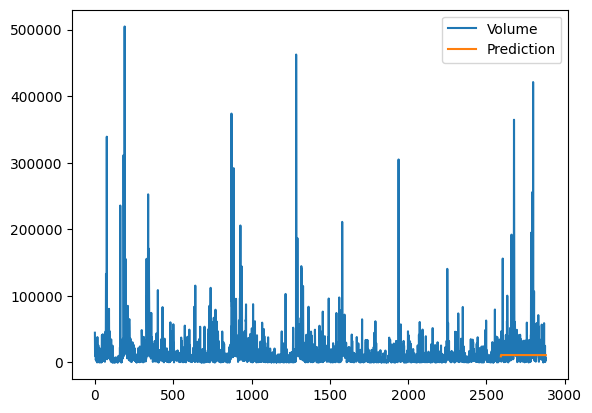

In [163]:
plt.figure(figsize=(10, 20))
    
temp_df = pd.concat([vdf4, forecast], axis=1)
temp_df.plot()
plt.show()

In [164]:
metrics.r2_score(test, forecast)

-0.1145777894576463

In [165]:
# Linear Regression

scaled_x, scaled_y, scaler_x, scaler_y = get_scaled(df3[['RSI', 'Volume']], 'Volume', 5)

regressor = LinearRegression()
get_model_metrics(scaled_x, scaled_y, regressor, 'LinearRegression')

Input:  Index(['RSI(t-1)', 'Volume(t-1)', 'RSI(t-2)', 'Volume(t-2)', 'RSI(t-3)',
       'Volume(t-3)', 'RSI(t-4)', 'Volume(t-4)', 'RSI(t-5)', 'Volume(t-5)'],
      dtype='object')
Target: Volume


{'r2 train': '0.17',
 'r2 test': '0.12',
 'mse train': '0.00',
 'mse test': '0.00',
 'model': 'LinearRegression'}

In [166]:
scaled_x

array([[0.75958461, 0.01796993, 0.7235221 , ..., 0.02782   , 0.60454435,
        0.08856738],
       [0.60856003, 0.05907068, 0.75958461, ..., 0.02601251, 0.63684226,
        0.02782   ],
       [0.5551086 , 0.00724981, 0.60856003, ..., 0.04472565, 0.65266153,
        0.02601251],
       ...,
       [0.61786036, 0.00954486, 0.61786036, ..., 0.0107122 , 0.52911262,
        0.0041402 ],
       [0.65601877, 0.00968359, 0.61786036, ..., 0.04964871, 0.5685312 ,
        0.0107122 ],
       [0.58468494, 0.0068237 , 0.65601877, ..., 0.00126049, 0.60568647,
        0.04964871]])

In [167]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, scaled_y, test_size=0.3, shuffle=False)

In [168]:
train_x_LSTM = X_train.reshape((X_train.shape[0], 1, 10))
test_x_LSTM = X_test.reshape((X_test.shape[0], 1, 10))

In [169]:
# LSTM Model

batch_size=int(y_train.shape[0])
model = Sequential()
model.add(LSTM(100, input_shape=(train_x_LSTM.shape[1], train_x_LSTM.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1])) #activation='sigmoid'
model.compile(loss='mean_squared_error', optimizer='adam')

In [170]:
history = model.fit(train_x_LSTM, y_train, epochs=100, batch_size=batch_size,
                    validation_data=(test_x_LSTM, y_test), verbose=1, shuffle=False, callbacks=[])

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0047 - val_loss: 0.0032
Epoch 2/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 5/100
1/1 [==============================] - 0s 66ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 6/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 7/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 8/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 11/100
1/1 [===

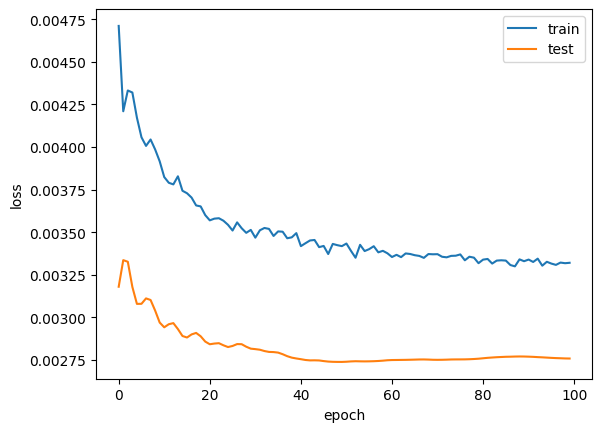

In [171]:
 
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [172]:
res_tr_LSTM = model.predict(train_x_LSTM)
res_ts_LSTM = model.predict(test_x_LSTM)

27/27 [==============================] - 0s 2ms/step


In [173]:
get_metrics(y_train, res_tr_LSTM, y_test, res_ts_LSTM)

{'r2 train': '0.18',
 'r2 test': '0.13',
 'mse train': '0.00',
 'mse test': '0.00'}